In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
#import pandas_datareader.data as web

In [3]:
# 1. LOAD MORE HISTORY (2010 - 2024)
tickers = ['^GSPC', '^VIX', '^TNX', 'CL=F']
print("Downloading Deep History (2010-2024)...")
data = yf.download(tickers, start='2010-01-01', end='2024-01-01', auto_adjust=False)['Close']

[*********************100%***********************]  4 of 4 completed


In [4]:
data

Ticker,CL=F,^GSPC,^TNX,^VIX
Date,,,,
2010-01-04,81.510002,1132.989990,3.841,20.040001
2010-01-05,81.769997,1136.520020,3.755,19.350000
2010-01-06,83.180000,1137.140015,3.808,19.160000
2010-01-07,82.660004,1141.689941,3.822,19.059999
2010-01-08,82.750000,1144.979980,3.808,18.129999
...,...,...,...,...
2023-12-22,73.559998,4754.629883,3.901,13.030000
2023-12-26,75.570000,4774.750000,3.886,12.990000
2023-12-27,74.110001,4781.580078,3.789,12.430000


In [5]:
# 2. CLEAN DATA
# Forward fill (ffill) to handle slight timezone differences in data availability
data.ffill(inplace=True)


# 3. CREATE FEATURES (The Input for PCA)
df_macro = pd.DataFrame(index=data.index)

In [6]:
# If pandas_ta isn't installed, we can calculate RSI manually with numpy:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [7]:
# --- MACRO FEATURES (For Regime Detection) ---
df_macro['SP500_Return'] = data['^GSPC'].pct_change()
df_macro['SP500_Vol'] = df_macro['SP500_Return'].rolling(20).std()
df_macro['VIX'] = data['^VIX'] / 100
df_macro['Bond_Yield'] = data['^TNX'] / 100
df_macro['Oil_Change'] = data['CL=F'].pct_change()

# --- TECHNICAL FEATURES (For the XGBoost Trader) ---
# SMA 50: The long-term trend line
df_macro['SMA_50'] = data['^GSPC'].rolling(window=50).mean()
# "Signal": 1 if price is above trend, 0 if below
df_macro['Above_SMA'] = (data['^GSPC'] > df_macro['SMA_50']).astype(int)
# Momentum: Return over the last 5 days
df_macro['Momentum'] = data['^GSPC'].pct_change(periods=5)
# 2. RSI (Momentum/Exhaustion) - The "Sniper" Feature
# RSI > 70 = Overbought (Sell signal in Bear markets)
# RSI < 30 = Oversold (Buy signal in Bull markets)
df_macro['RSI'] = calculate_rsi(data['^GSPC'])

df_macro.dropna(inplace=True)
print("Data Ready! Total Rows:", len(df_macro))
print(df_macro.head())

Data Ready! Total Rows: 3473
            SP500_Return  SP500_Vol     VIX  Bond_Yield  Oil_Change  \
Date                                                                  
2010-03-16      0.007779   0.005466  0.1769     0.03653    0.023809   
2010-03-17      0.005822   0.005498  0.1691     0.03642    0.015055   
2010-03-18     -0.000326   0.005475  0.1662     0.03672   -0.008803   
2010-03-19     -0.005086   0.005741  0.1697     0.03687   -0.018491   
2010-03-22      0.005095   0.005719  0.1687     0.03663    0.007065   

                 SMA_50  Above_SMA  Momentum        RSI  
Date                                                     
2010-03-16  1113.826594          1  0.016669  95.395175  
2010-03-17  1114.490994          1  0.017982  99.298813  
2010-03-18  1115.077192          1  0.013554  98.682607  
2010-03-19  1115.532393          1  0.008617  88.286421  
2010-03-22  1116.014795          1  0.013298  88.921808  


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [9]:
# 1. STANDARDIZE THE DATA (Critical Step!)
# PCA is sensitive to scale. VIX is ~20, Returns are ~0.01.
# If we don't scale, PCA will think VIX is the only important thing because it's big.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_macro)

In [10]:
scaled_data

array([[ 0.66134519, -0.64889483, -0.11931009, ...,  0.65155836,
         0.63165539,  2.39176762],
       [ 0.48421076, -0.64356409, -0.22846534, ...,  0.65155836,
         0.6894284 ,  2.63153463],
       [-0.07209621, -0.64730296, -0.26904853, ...,  0.65155836,
         0.49456285,  2.59368637],
       ...,
       [ 0.08683678, -0.55981361, -0.85540775, ...,  0.65155836,
         0.02001471,  1.51566604],
       [-0.0091113 , -0.56515083, -0.84981005, ...,  0.65155836,
         0.69426006,  1.39762248],
       [-0.29838534, -0.54716536, -0.85260897, ...,  0.65155836,
         0.11207676,  1.12828564]])

In [11]:
# 2. RUN PCA
# We want to compress 5 dimensions down to 2
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_data)

In [12]:
pca_results

array([[-2.2511034 ,  0.17644227],
       [-2.37778643,  0.13289003],
       [-2.15965674, -0.27868963],
       ...,
       [-1.55249553, -0.6165604 ],
       [-1.69775412, -0.41216197],
       [-1.35211898, -0.84188367]])

In [13]:
# 3. CREATE THE NEW DATAFRAME
df_pca = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'], index=df_macro.index)
df_pca.head(5)

,PC1,PC2
Date,,
2010-03-16,-2.251103,0.176442
2010-03-17,-2.377786,0.132890
2010-03-18,-2.159657,-0.278690
2010-03-19,-1.649838,-0.695971
2010-03-22,-1.983077,-0.132216


In [14]:
# 4. CHECK THE "EXPLAINED VARIANCE"
# This tells us: "How much of the total market story did we capture with just 2 variables?"
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Captured Variance: {explained_variance*100:.2f}%")

Captured Variance: 47.80%


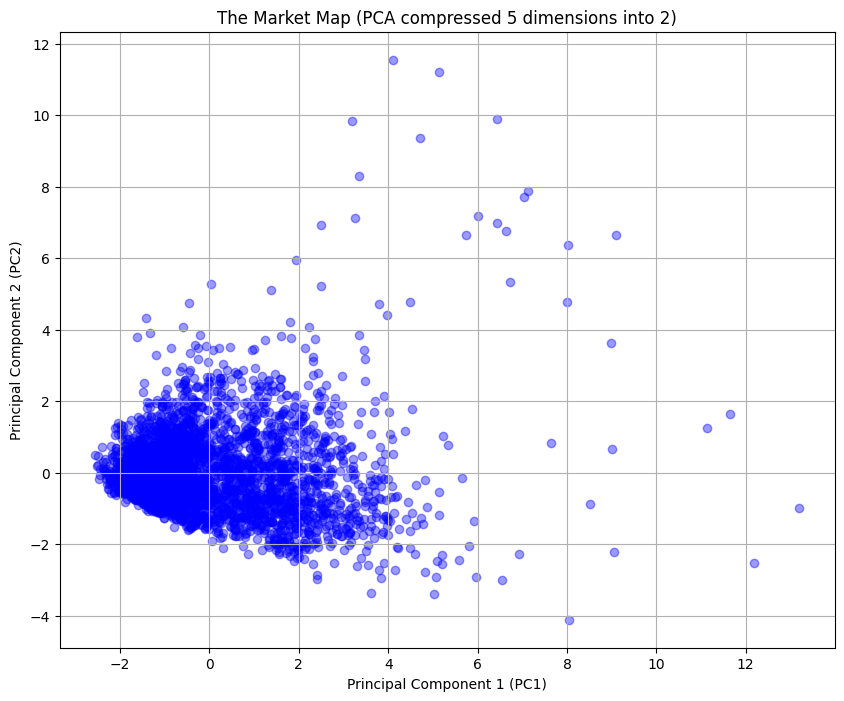

In [15]:
# 5. VISUALIZE THE "MASTER MAP"
plt.figure(figsize=(10, 8))
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.4, c='blue')
plt.title('The Market Map (PCA compressed 5 dimensions into 2)')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.grid(True)
plt.show()

In [16]:
# 6. WHAT DO THESE COMPONENTS MEAN? (The "Loadings")
# This tells us which original columns make up PC1 and PC2
print("\n--- PCA Loadings (What makes up the new axes?) ---")
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=df_macro.columns)
print(loadings)


--- PCA Loadings (What makes up the new axes?) ---
                   PC1       PC2
SP500_Return -0.214112  0.466115
SP500_Vol     0.406413  0.515150
VIX           0.489538  0.349060
Bond_Yield   -0.039286 -0.340763
Oil_Change   -0.095647  0.065656
SMA_50        0.073224  0.081903
Above_SMA    -0.459572  0.073690
Momentum     -0.349581  0.464193
RSI          -0.447068  0.217877


In [17]:
# 1. APPLY K-MEANS TO THE PCA DATA
# We use the compressed data (PC1, PC2) instead of the raw 5 columns
kmeans_pca = KMeans(n_clusters=2, random_state=42)
df_pca['Cluster'] = kmeans_pca.fit_predict(df_pca)

In [18]:
df_pca.head(2)

,PC1,PC2,Cluster
Date,,,
2010-03-16,-2.251103,0.176442,0
2010-03-17,-2.377786,0.132890,0


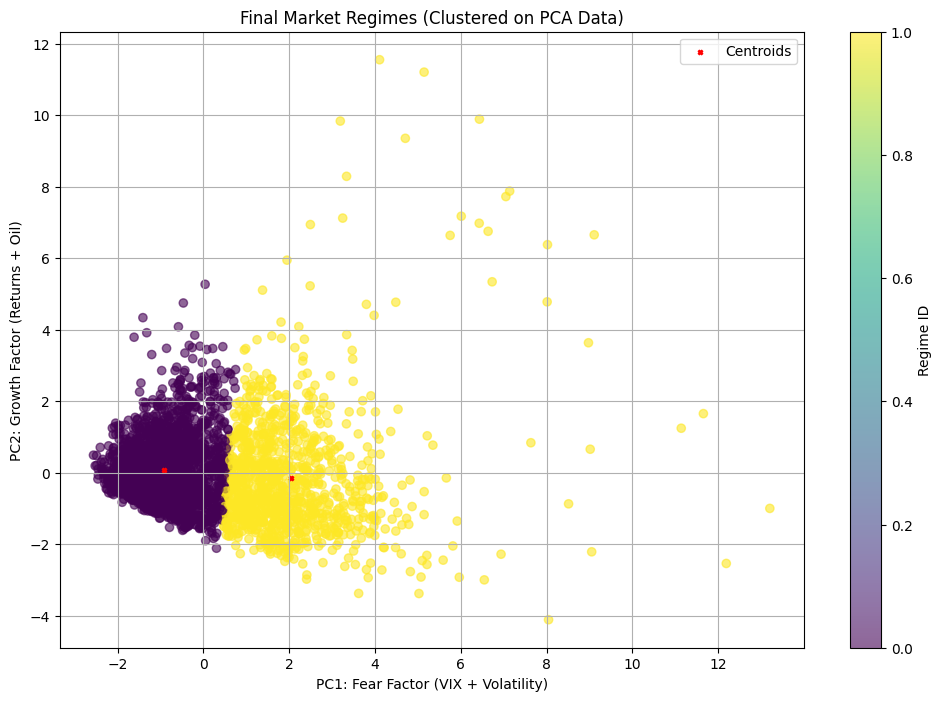

In [19]:
# 2. VISUALIZE THE FINAL "CHAMELEON" MAP
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Cluster'], cmap='viridis', alpha=0.6)

# Add centroids (the "Heart" of each regime)
centroids = kmeans_pca.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=10, marker='X', label='Centroids')

plt.title('Final Market Regimes (Clustered on PCA Data)')
plt.xlabel('PC1: Fear Factor (VIX + Volatility)')
plt.ylabel('PC2: Growth Factor (Returns + Oil)')
plt.legend()
plt.colorbar(scatter, label='Regime ID')
plt.grid(True)
plt.show()

In [20]:
# 3. SAVE THE MODEL (MLOps Step)
# We need to save this logic so we can use it tomorrow without re-training
import joblib

In [21]:
print("Saving models...")
joblib.dump(scaler, 'scaler.gz')   # Save the scaling logic
joblib.dump(pca, 'pca.gz')         # Save the compression logic
joblib.dump(kmeans_pca, 'kmeans.gz') # Save the clustering brain
print("Phase 1 Complete: Models Saved!")

Saving models...
Phase 1 Complete: Models Saved!


# ***XGBoost -> the brain***

In [22]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [23]:
# 1. PREPARE THE TARGET (What are we predicting?)
# We want to predict: Will the S&P 500 go UP tomorrow? (1 = Yes, 0 = No)
# Shift -1 looks at the *next* day's return
df_pca['Target'] = (df_macro['SP500_Return'].shift(-1) > 0).astype(int)

In [24]:
# Add the original features back to our PCA data so XGBoost can use them
# (XGBoost is smarter than PCA, so let's give it the raw data + the cluster info)
final_df = pd.concat([df_macro, df_pca[['Cluster']]], axis=1)
final_df['Target'] = df_pca['Target']
final_df.dropna(inplace=True)
final_df.head(5)

,SP500_Return,SP500_Vol,VIX,Bond_Yield,Oil_Change,SMA_50,Above_SMA,Momentum,RSI,Cluster,Target
Date,,,,,,,,,,,
2010-03-16,0.007779,0.005466,0.1769,0.03653,0.023809,1113.826594,1,0.016669,95.395175,0,1
2010-03-17,0.005822,0.005498,0.1691,0.03642,0.015055,1114.490994,1,0.017982,99.298813,0,0
2010-03-18,-0.000326,0.005475,0.1662,0.03672,-0.008803,1115.077192,1,0.013554,98.682607,0,0
2010-03-19,-0.005086,0.005741,0.1697,0.03687,-0.018491,1115.532393,1,0.008617,88.286421,0,1
2010-03-22,0.005095,0.005719,0.1687,0.03663,0.007065,1116.014795,1,0.013298,88.921808,0,1


In [25]:
# 2. THE LOOP: TRAIN 3 SEPARATE MODELS
models = {} # Dictionary to store our 3 xgboost  models.
for cluster_id in range(2):
    print(f"\nTraining Trader for Regime {cluster_id}...")

    # A. FILTER: Get only the days belonging to this specific regime
    regime_data = final_df[final_df['Cluster'] == cluster_id]

    # B. SPLIT: Train/Test
    X = regime_data.drop(columns=['Target', 'Cluster', 'SMA_50']) # Input features
    y = regime_data['Target'] # Buy (1) or Sell (0)

    # Need enough data to train (at least 50 days)
    if len(X) < 50:
        print(f"  Skipping Cluster {cluster_id} (Not enough data)")
        continue

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    # C. TRAIN XGBOOST
    model = xgb.XGBClassifier(
        n_estimators=50,      # Number of trees
        max_depth=3,          # Keep trees shallow to avoid overfitting
        learning_rate=0.1,
        random_state=42
    )
    model.fit(X_train, y_train)

    # D. EVALUATE
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"  Trader {cluster_id} Accuracy: {acc*100:.2f}%")

    # E. SAVE THE BRAIN
    models[cluster_id] = model
    joblib.dump(model, f'xgb_regime_{cluster_id}.gz')


Training Trader for Regime 0...
  Trader 0 Accuracy: 50.00%

Training Trader for Regime 1...
  Trader 1 Accuracy: 49.77%


## backtest

In [26]:
final_df.head(5)

,SP500_Return,SP500_Vol,VIX,Bond_Yield,Oil_Change,SMA_50,Above_SMA,Momentum,RSI,Cluster,Target
Date,,,,,,,,,,,
2010-03-16,0.007779,0.005466,0.1769,0.03653,0.023809,1113.826594,1,0.016669,95.395175,0,1
2010-03-17,0.005822,0.005498,0.1691,0.03642,0.015055,1114.490994,1,0.017982,99.298813,0,0
2010-03-18,-0.000326,0.005475,0.1662,0.03672,-0.008803,1115.077192,1,0.013554,98.682607,0,0
2010-03-19,-0.005086,0.005741,0.1697,0.03687,-0.018491,1115.532393,1,0.008617,88.286421,0,1
2010-03-22,0.005095,0.005719,0.1687,0.03663,0.007065,1116.014795,1,0.013298,88.921808,0,1


In [27]:
# ==========================================
# FINAL CORRECTED BACKTEST (Vectorized)
# ==========================================
print("--- RUNNING VECTORIZED BACKTEST ---")

# 1. GENERATE SIGNALS (No Looping)
# Create a placeholder column for signals
final_df['Signal'] = 0

--- RUNNING VECTORIZED BACKTEST ---


In [29]:
final_df.head(2)

,SP500_Return,SP500_Vol,VIX,Bond_Yield,Oil_Change,SMA_50,Above_SMA,Momentum,RSI,Cluster,Target,Signal
Date,,,,,,,,,,,,
2010-03-16,0.007779,0.005466,0.1769,0.03653,0.023809,1113.826594,1,0.016669,95.395175,0,1,0
2010-03-17,0.005822,0.005498,0.1691,0.03642,0.015055,1114.490994,1,0.017982,99.298813,0,0,0


Regime 0 (FOLLOW): Accuracy 61.92%
Regime 1 (FOLLOW): Accuracy 67.77%


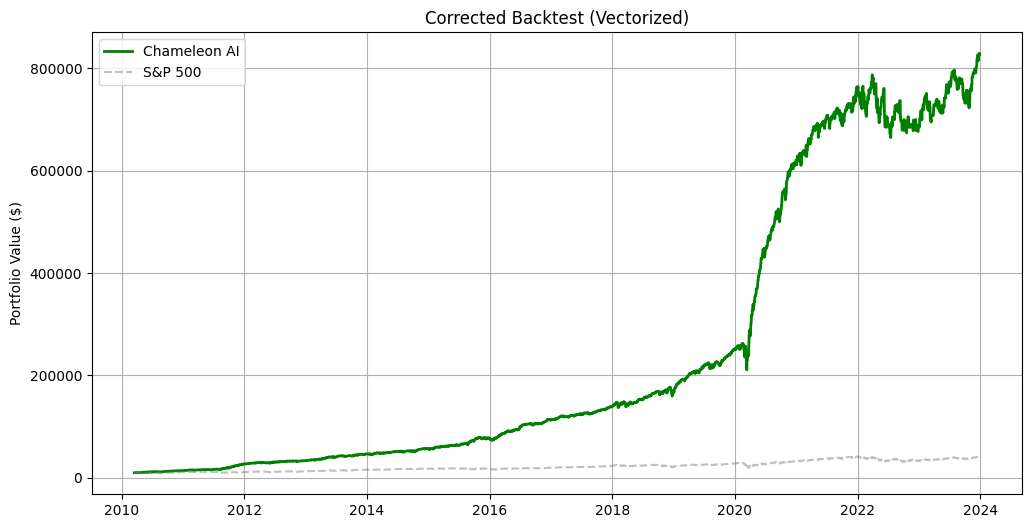

Final Value: $827,281.82
Total Return: 8172.82%


In [30]:
for cluster_id, model in models.items():
    # Identify which days belong to this regime
    idxs = final_df.index[final_df['Cluster'] == cluster_id]

    if len(idxs) == 0: continue

    # Get features for these days
    X_regime = final_df.loc[idxs].drop(columns=['Target', 'Cluster', 'SMA_50','Signal'])

    # Predict (1 = Up, 0 = Down)
    preds = model.predict(X_regime)

    # Get Strategy (Follow vs Invert)
    # Re-verify accuracy on this slice to be sure
    acc = accuracy_score(final_df.loc[idxs, 'Target'], preds)
    strategy = "INVERT" if acc < 0.50 else "FOLLOW"
    print(f"Regime {cluster_id} ({strategy}): Accuracy {acc*100:.2f}%")

    # Convert 0/1 to -1/1 (Short/Long)
    # If Pred=1 (Up) & Follow -> 1 (Long)
    # If Pred=1 (Up) & Invert -> -1 (Short)
    # If Pred=0 (Down) & Follow -> 0 (Cash) or -1 (Short)? Let's assume 0 (Cash) for safety, or -1 for aggressive.
    # Let's stick to your logic: 1 vs 0 becomes 1 vs -1 for the Invert.

    if strategy == "FOLLOW":
        # Pred 1 -> Signal 1 (Long)
        # Pred 0 -> Signal 0 (Cash) - Safer than shorting in a bull regime
        signals = np.where(preds == 1, 1, 0)
    else:
        # INVERT (Mean Reversion)
        # Pred 1 (Model says Up) -> Signal -1 (We Short)
        # Pred 0 (Model says Down) -> Signal 1 (We Buy)
        signals = np.where(preds == 1, -1, 1)

    final_df.loc[idxs, 'Signal'] = signals

# 2. THE "SHIFT" (Fixes the Time Travel Bug)
# We move signals forward by 1 day.
# The signal generated on Monday Close applies to Tuesday's Return.
final_df['Signal_Shifted'] = final_df['Signal'].shift(1)

# 3. CALCULATE RETURNS
# Strategy Return = Signal * Market Return
final_df['Strategy_Return'] = final_df['Signal_Shifted'] * final_df['SP500_Return']

# 4. CALCULATE EQUITY CURVE
initial_capital = 10000
# cumprod() calculates cumulative compound returns
final_df['Equity_Curve'] = initial_capital * (1 + final_df['Strategy_Return']).cumprod()
final_df['Benchmark'] = initial_capital * (1 + final_df['SP500_Return']).cumprod()

# 5. PLOT
plt.figure(figsize=(12, 6))
plt.plot(final_df['Equity_Curve'], label='Chameleon AI', color='green', linewidth=2)
plt.plot(final_df['Benchmark'], label='S&P 500', color='gray', linestyle='--', alpha=0.5)
plt.title('Corrected Backtest (Vectorized)')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

# 6. FINAL STATS
final_val = final_df['Equity_Curve'].iloc[-1]
total_ret = ((final_val - initial_capital) / initial_capital) * 100
print(f"Final Value: ${final_val:,.2f}")
print(f"Total Return: {total_ret:.2f}%")